In [23]:
import requests
from bs4 import BeautifulSoup

In [29]:
HTML_markup = (requests.get("https://fbref.com/en/squads/361ca564/Tottenham-Hotspur-Stats")).text
parsed_code = BeautifulSoup(HTML_markup, 'html.parser')

In [35]:
#parsed_code


<!DOCTYPE html>

<html class="no-js" data-root="/home/fb/deploy/www/base" data-version="klecko-" lang="en">
<head>
<meta charset="utf-8"/>
<meta content="ie=edge" http-equiv="x-ua-compatible"/>
<meta content="width=device-width, initial-scale=1.0, maximum-scale=2.0" name="viewport">
<link href="https://cdn.ssref.net/req/202309261" rel="dns-prefetch"/>
<!-- Quantcast Choice. Consent Manager Tag v2.0 (for TCF 2.0) -->
<script async="true" type="text/javascript">
    (function() {
	var host = window.location.hostname;
	var element = document.createElement('script');
	var firstScript = document.getElementsByTagName('script')[0];
	var url = 'https://cmp.quantcast.com'
	    .concat('/choice/', 'XwNYEpNeFfhfr', '/', host, 
		    '/choice.js?tag_version=V2');
	var uspTries = 0;
	var uspTriesLimit = 3;
	element.async = true;
	element.type = 'text/javascript';
	element.src = url;
	
	firstScript.parentNode.insertBefore(element, firstScript);
	
	function makeStub() {
	    var TCF_LOCATOR_NAME = '

In [51]:
table = parsed_code.find_all("div", attrs={'table_wrapper tabbed'})
def is_desired_td(tag):
    return tag.name == 'td' and tag.has_attr('data-stat') and tag['data-stat'] in ["goals_for", "goals_against", "opponent"]
values = parsed_code.find_all(is_desired_td)
#print(values)

[<td class="right" csk="2" data-stat="goals_for">2</td>, <td class="right" csk="2" data-stat="goals_against">2</td>, <td class="left" data-stat="opponent"><a href="/en/squads/cd051869/Brentford-Stats">Brentford</a></td>, <td class="right" csk="2" data-stat="goals_for">2</td>, <td class="right iz" csk="0" data-stat="goals_against">0</td>, <td class="left" data-stat="opponent"><a href="/en/squads/19538871/Manchester-United-Stats">Manchester Utd</a></td>, <td class="right" csk="2" data-stat="goals_for">2</td>, <td class="right iz" csk="0" data-stat="goals_against">0</td>, <td class="left" data-stat="opponent"><a href="/en/squads/4ba7cbea/Bournemouth-Stats">Bournemouth</a></td>, <td class="right" csk="1" data-stat="goals_for">1 <small>(3)</small></td>, <td class="right" csk="1" data-stat="goals_against">1 <small>(5)</small></td>, <td class="left" data-stat="opponent"><a href="/en/squads/fd962109/Fulham-Stats">Fulham</a></td>, <td class="right" csk="5" data-stat="goals_for">5</td>, <td clas

In [56]:
years = []

for year in range(2023, 20, -1):
    academic_year = f"{year}-{year + 1}"
    years.append(academic_year)

# Print the list of academic years
print(years)

['2023-2024', '2022-2023', '2021-2022', '2020-2021', '2019-2020', '2018-2019', '2017-2018', '2016-2017', '2015-2016', '2014-2015', '2013-2014', '2012-2013', '2011-2012', '2010-2011', '2009-2010', '2008-2009', '2007-2008', '2006-2007', '2005-2006', '2004-2005', '2003-2004', '2002-2003', '2001-2002', '2000-2001']


_____________________________________________________2023-2024____________________________________

<!DOCTYPE html>
<html data-version="klecko-" data-root="" lang="en" class="no-js" >
<head id="suppress_all_ads">
    <meta charset="utf-8">
    <meta http-equiv="x-ua-compatible" content="ie=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=2.0" />

    <title>Rate Limited Request (429 error) | Sports-Reference.com</title>

    <link rel="canonical" href="https://www.sports-reference.com/429.html" />

<!-- CSS start -->
 <style>body,html{color:#000;font:14px/1.25 Helvetica Neue,helvetica,arial,sans-serif;margin:0;padding:0}html:not(.backstop){scroll-behavior:smooth}html:not(.backstop) div,html:not(.backstop) span{scroll-snap-margin:2.5em 0 0 0;scroll-margin:2.5em 0 0 0}body{-webkit-text-size-adjust:none;-moz-text-size-adjust:none;-ms-text-size-adjust:none;background:#c9cbcd;position:relative;z-index:0}a img{border:0}li,ol,ul{list-style-type:no
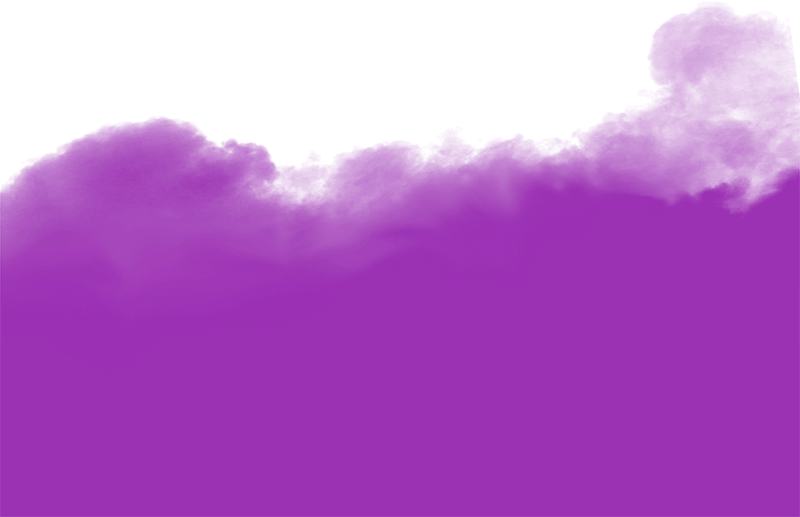

_____________________________________________________2022-2023____________________________________

<!DOCTYPE html>
<html data-version="klecko-" data-root="" lang="en" class="no-js" >
<head id="suppress_all_ads">
    <meta charset="utf-8">
    <meta http-equiv="x-ua-compatible" content="ie=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=2.0" />

    <title>Rate Limited Request (429 error) | Sports-Reference.com</title>

    <link rel="canonical" href="https://www.sports-reference.com/429.html" />

<!-- CSS start -->
 <style>body,html{color:#000;font:14px/1.25 Helvetica Neue,helvetica,arial,sans-serif;margin:0;padding:0}html:not(.backstop){scroll-behavior:smooth}html:not(.backstop) div,html:not(.backstop) span{scroll-snap-margin:2.5em 0 0 0;scroll-margin:2.5em 0 0 0}body{-webkit-text-size-adjust:none;-moz-text-size-adjust:none;-ms-text-size-adjust:none;background:#c9cbcd;position:relative;z-index:0}a img{border:0}li,ol,ul{list-style-type:no
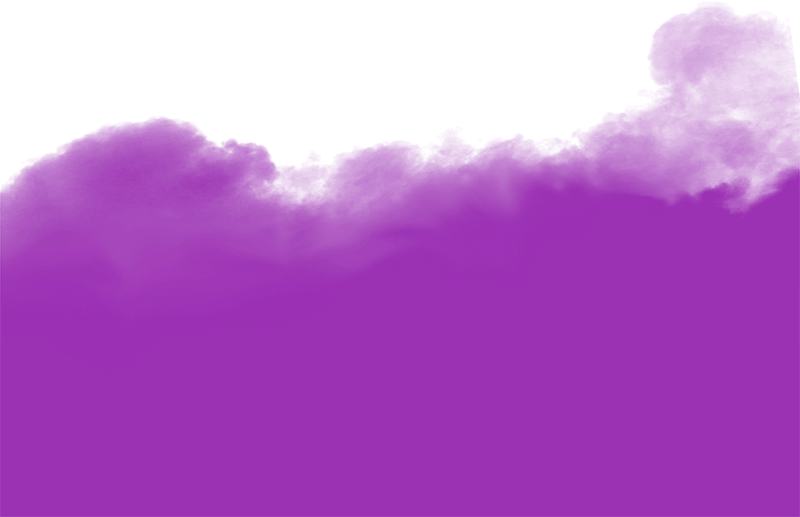

_____________________________________________________2021-2022____________________________________

<!DOCTYPE html>
<html data-version="klecko-" data-root="" lang="en" class="no-js" >
<head id="suppress_all_ads">
    <meta charset="utf-8">
    <meta http-equiv="x-ua-compatible" content="ie=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=2.0" />

    <title>Rate Limited Request (429 error) | Sports-Reference.com</title>

    <link rel="canonical" href="https://www.sports-reference.com/429.html" />

<!-- CSS start -->
 <style>body,html{color:#000;font:14px/1.25 Helvetica Neue,helvetica,arial,sans-serif;margin:0;padding:0}html:not(.backstop){scroll-behavior:smooth}html:not(.backstop) div,html:not(.backstop) span{scroll-snap-margin:2.5em 0 0 0;scroll-margin:2.5em 0 0 0}body{-webkit-text-size-adjust:none;-moz-text-size-adjust:none;-ms-text-size-adjust:none;background:#c9cbcd;position:relative;z-index:0}a img{border:0}li,ol,ul{list-style-type:no
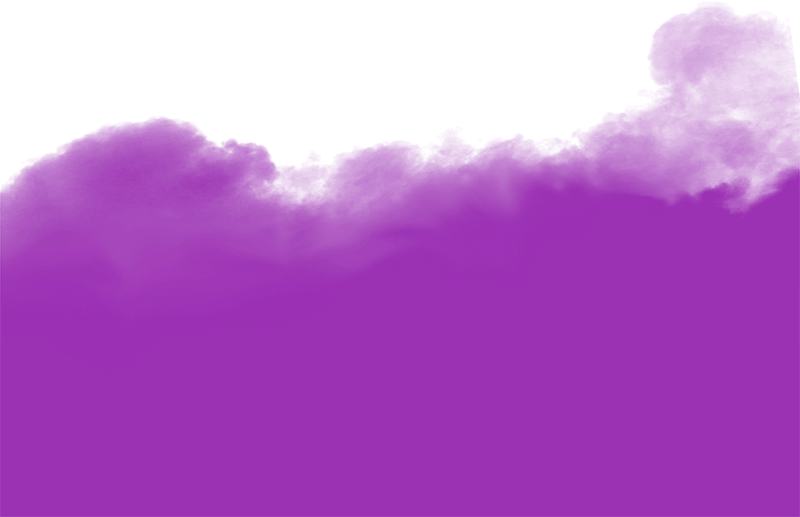

_____________________________________________________2020-2021____________________________________

<!DOCTYPE html>
<html data-version="klecko-" data-root="" lang="en" class="no-js" >
<head id="suppress_all_ads">
    <meta charset="utf-8">
    <meta http-equiv="x-ua-compatible" content="ie=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=2.0" />

    <title>Rate Limited Request (429 error) | Sports-Reference.com</title>

    <link rel="canonical" href="https://www.sports-reference.com/429.html" />

<!-- CSS start -->
 <style>body,html{color:#000;font:14px/1.25 Helvetica Neue,helvetica,arial,sans-serif;margin:0;padding:0}html:not(.backstop){scroll-behavior:smooth}html:not(.backstop) div,html:not(.backstop) span{scroll-snap-margin:2.5em 0 0 0;scroll-margin:2.5em 0 0 0}body{-webkit-text-size-adjust:none;-moz-text-size-adjust:none;-ms-text-size-adjust:none;background:#c9cbcd;position:relative;z-index:0}a img{border:0}li,ol,ul{list-style-type:no
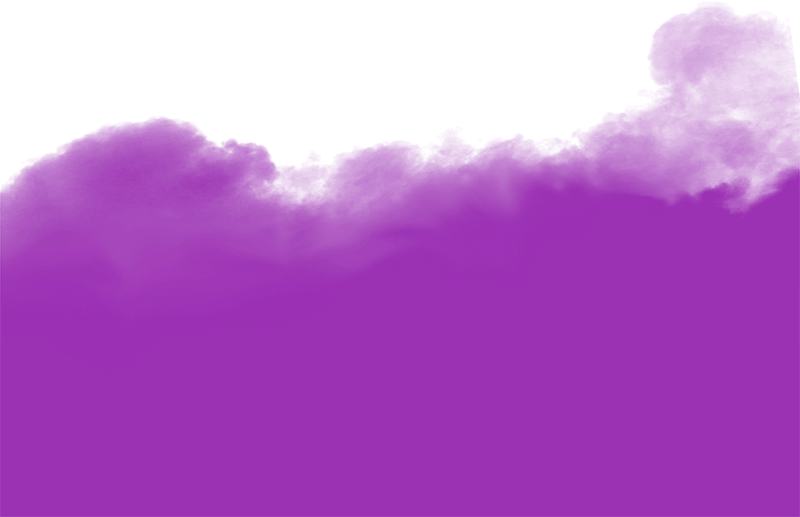

_____________________________________________________2019-2020____________________________________

<!DOCTYPE html>
<html data-version="klecko-" data-root="" lang="en" class="no-js" >
<head id="suppress_all_ads">
    <meta charset="utf-8">
    <meta http-equiv="x-ua-compatible" content="ie=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=2.0" />

    <title>Rate Limited Request (429 error) | Sports-Reference.com</title>

    <link rel="canonical" href="https://www.sports-reference.com/429.html" />

<!-- CSS start -->
 <style>body,html{color:#000;font:14px/1.25 Helvetica Neue,helvetica,arial,sans-serif;margin:0;padding:0}html:not(.backstop){scroll-behavior:smooth}html:not(.backstop) div,html:not(.backstop) span{scroll-snap-margin:2.5em 0 0 0;scroll-margin:2.5em 0 0 0}body{-webkit-text-size-adjust:none;-moz-text-size-adjust:none;-ms-text-size-adjust:none;background:#c9cbcd;position:relative;z-index:0}a img{border:0}li,ol,ul{list-style-type:no
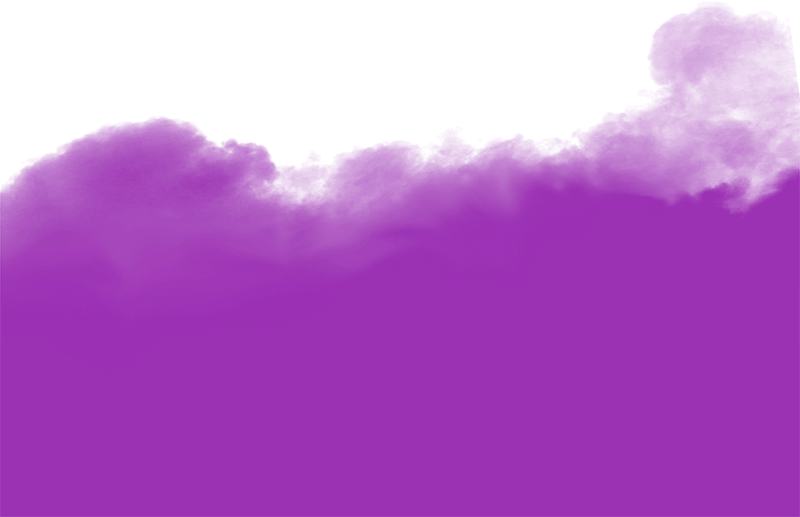

_____________________________________________________2018-2019____________________________________

<!DOCTYPE html>
<html data-version="klecko-" data-root="" lang="en" class="no-js" >
<head id="suppress_all_ads">
    <meta charset="utf-8">
    <meta http-equiv="x-ua-compatible" content="ie=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=2.0" />

    <title>Rate Limited Request (429 error) | Sports-Reference.com</title>

    <link rel="canonical" href="https://www.sports-reference.com/429.html" />

<!-- CSS start -->
 <style>body,html{color:#000;font:14px/1.25 Helvetica Neue,helvetica,arial,sans-serif;margin:0;padding:0}html:not(.backstop){scroll-behavior:smooth}html:not(.backstop) div,html:not(.backstop) span{scroll-snap-margin:2.5em 0 0 0;scroll-margin:2.5em 0 0 0}body{-webkit-text-size-adjust:none;-moz-text-size-adjust:none;-ms-text-size-adjust:none;background:#c9cbcd;position:relative;z-index:0}a img{border:0}li,ol,ul{list-style-type:no
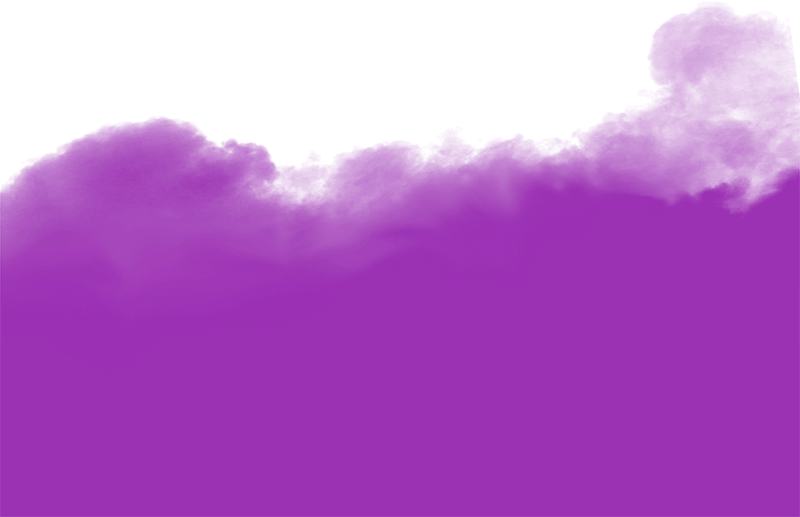

_____________________________________________________2017-2018____________________________________

<!DOCTYPE html>
<html data-version="klecko-" data-root="" lang="en" class="no-js" >
<head id="suppress_all_ads">
    <meta charset="utf-8">
    <meta http-equiv="x-ua-compatible" content="ie=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=2.0" />

    <title>Rate Limited Request (429 error) | Sports-Reference.com</title>

    <link rel="canonical" href="https://www.sports-reference.com/429.html" />

<!-- CSS start -->
 <style>body,html{color:#000;font:14px/1.25 Helvetica Neue,helvetica,arial,sans-serif;margin:0;padding:0}html:not(.backstop){scroll-behavior:smooth}html:not(.backstop) div,html:not(.backstop) span{scroll-snap-margin:2.5em 0 0 0;scroll-margin:2.5em 0 0 0}body{-webkit-text-size-adjust:none;-moz-text-size-adjust:none;-ms-text-size-adjust:none;background:#c9cbcd;position:relative;z-index:0}a img{border:0}li,ol,ul{list-style-type:no
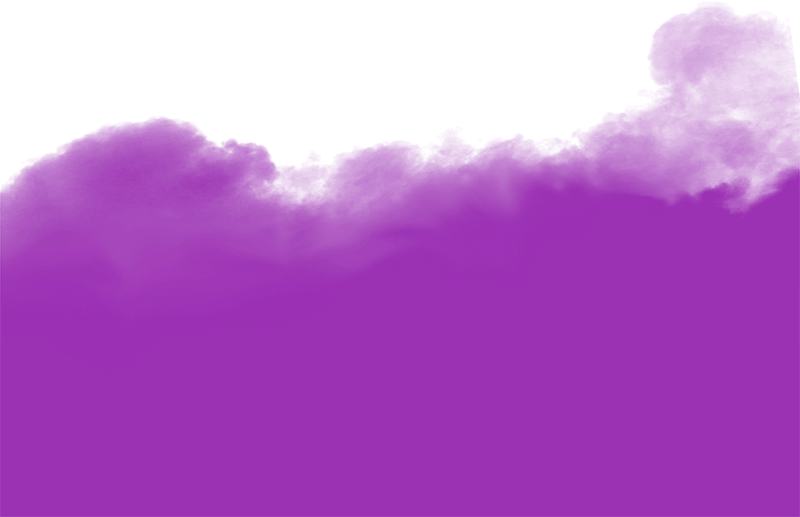

_____________________________________________________2016-2017____________________________________

<!DOCTYPE html>
<html data-version="klecko-" data-root="" lang="en" class="no-js" >
<head id="suppress_all_ads">
    <meta charset="utf-8">
    <meta http-equiv="x-ua-compatible" content="ie=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=2.0" />

    <title>Rate Limited Request (429 error) | Sports-Reference.com</title>

    <link rel="canonical" href="https://www.sports-reference.com/429.html" />

<!-- CSS start -->
 <style>body,html{color:#000;font:14px/1.25 Helvetica Neue,helvetica,arial,sans-serif;margin:0;padding:0}html:not(.backstop){scroll-behavior:smooth}html:not(.backstop) div,html:not(.backstop) span{scroll-snap-margin:2.5em 0 0 0;scroll-margin:2.5em 0 0 0}body{-webkit-text-size-adjust:none;-moz-text-size-adjust:none;-ms-text-size-adjust:none;background:#c9cbcd;position:relative;z-index:0}a img{border:0}li,ol,ul{list-style-type:no
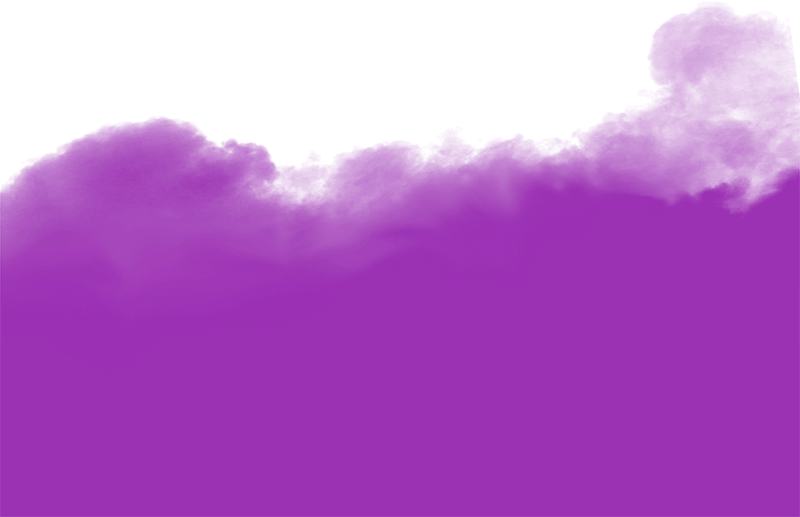

_____________________________________________________2015-2016____________________________________

<!DOCTYPE html>
<html data-version="klecko-" data-root="" lang="en" class="no-js" >
<head id="suppress_all_ads">
    <meta charset="utf-8">
    <meta http-equiv="x-ua-compatible" content="ie=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=2.0" />

    <title>Rate Limited Request (429 error) | Sports-Reference.com</title>

    <link rel="canonical" href="https://www.sports-reference.com/429.html" />

<!-- CSS start -->
 <style>body,html{color:#000;font:14px/1.25 Helvetica Neue,helvetica,arial,sans-serif;margin:0;padding:0}html:not(.backstop){scroll-behavior:smooth}html:not(.backstop) div,html:not(.backstop) span{scroll-snap-margin:2.5em 0 0 0;scroll-margin:2.5em 0 0 0}body{-webkit-text-size-adjust:none;-moz-text-size-adjust:none;-ms-text-size-adjust:none;background:#c9cbcd;position:relative;z-index:0}a img{border:0}li,ol,ul{list-style-type:no
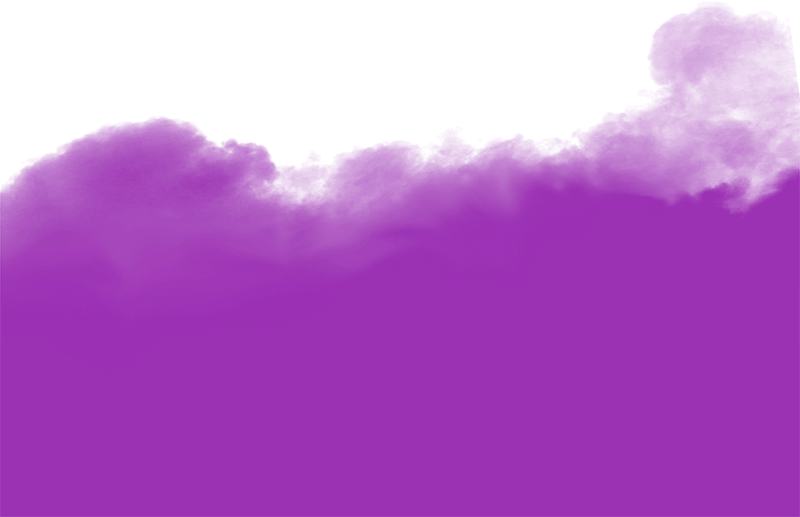

_____________________________________________________2014-2015____________________________________

<!DOCTYPE html>
<html data-version="klecko-" data-root="" lang="en" class="no-js" >
<head id="suppress_all_ads">
    <meta charset="utf-8">
    <meta http-equiv="x-ua-compatible" content="ie=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=2.0" />

    <title>Rate Limited Request (429 error) | Sports-Reference.com</title>

    <link rel="canonical" href="https://www.sports-reference.com/429.html" />

<!-- CSS start -->
 <style>body,html{color:#000;font:14px/1.25 Helvetica Neue,helvetica,arial,sans-serif;margin:0;padding:0}html:not(.backstop){scroll-behavior:smooth}html:not(.backstop) div,html:not(.backstop) span{scroll-snap-margin:2.5em 0 0 0;scroll-margin:2.5em 0 0 0}body{-webkit-text-size-adjust:none;-moz-text-size-adjust:none;-ms-text-size-adjust:none;background:#c9cbcd;position:relative;z-index:0}a img{border:0}li,ol,ul{list-style-type:no
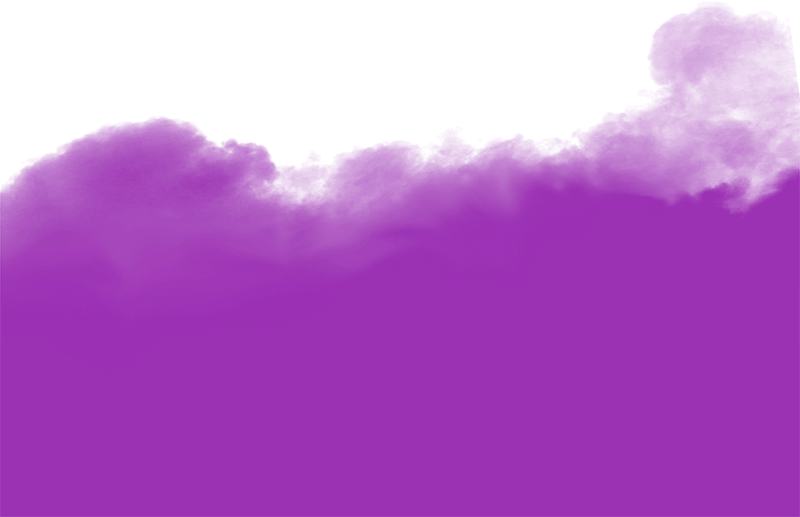

_____________________________________________________2013-2014____________________________________

<!DOCTYPE html>
<html data-version="klecko-" data-root="" lang="en" class="no-js" >
<head id="suppress_all_ads">
    <meta charset="utf-8">
    <meta http-equiv="x-ua-compatible" content="ie=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=2.0" />

    <title>Rate Limited Request (429 error) | Sports-Reference.com</title>

    <link rel="canonical" href="https://www.sports-reference.com/429.html" />

<!-- CSS start -->
 <style>body,html{color:#000;font:14px/1.25 Helvetica Neue,helvetica,arial,sans-serif;margin:0;padding:0}html:not(.backstop){scroll-behavior:smooth}html:not(.backstop) div,html:not(.backstop) span{scroll-snap-margin:2.5em 0 0 0;scroll-margin:2.5em 0 0 0}body{-webkit-text-size-adjust:none;-moz-text-size-adjust:none;-ms-text-size-adjust:none;background:#c9cbcd;position:relative;z-index:0}a img{border:0}li,ol,ul{list-style-type:no
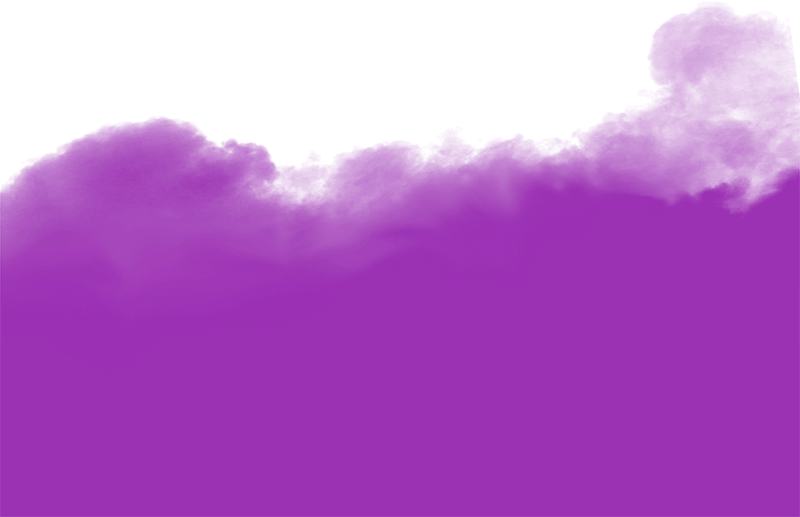

_____________________________________________________2012-2013____________________________________

<!DOCTYPE html>
<html data-version="klecko-" data-root="" lang="en" class="no-js" >
<head id="suppress_all_ads">
    <meta charset="utf-8">
    <meta http-equiv="x-ua-compatible" content="ie=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=2.0" />

    <title>Rate Limited Request (429 error) | Sports-Reference.com</title>

    <link rel="canonical" href="https://www.sports-reference.com/429.html" />

<!-- CSS start -->
 <style>body,html{color:#000;font:14px/1.25 Helvetica Neue,helvetica,arial,sans-serif;margin:0;padding:0}html:not(.backstop){scroll-behavior:smooth}html:not(.backstop) div,html:not(.backstop) span{scroll-snap-margin:2.5em 0 0 0;scroll-margin:2.5em 0 0 0}body{-webkit-text-size-adjust:none;-moz-text-size-adjust:none;-ms-text-size-adjust:none;background:#c9cbcd;position:relative;z-index:0}a img{border:0}li,ol,ul{list-style-type:no
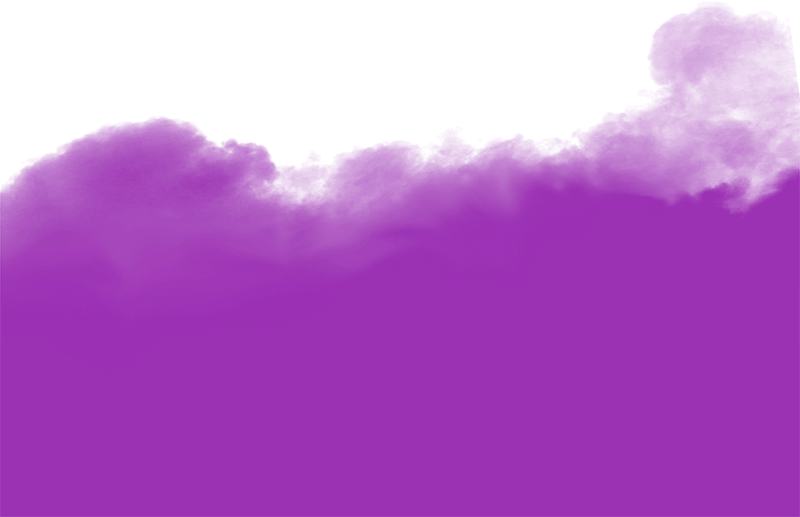

_____________________________________________________2011-2012____________________________________

<!DOCTYPE html>
<html data-version="klecko-" data-root="" lang="en" class="no-js" >
<head id="suppress_all_ads">
    <meta charset="utf-8">
    <meta http-equiv="x-ua-compatible" content="ie=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=2.0" />

    <title>Rate Limited Request (429 error) | Sports-Reference.com</title>

    <link rel="canonical" href="https://www.sports-reference.com/429.html" />

<!-- CSS start -->
 <style>body,html{color:#000;font:14px/1.25 Helvetica Neue,helvetica,arial,sans-serif;margin:0;padding:0}html:not(.backstop){scroll-behavior:smooth}html:not(.backstop) div,html:not(.backstop) span{scroll-snap-margin:2.5em 0 0 0;scroll-margin:2.5em 0 0 0}body{-webkit-text-size-adjust:none;-moz-text-size-adjust:none;-ms-text-size-adjust:none;background:#c9cbcd;position:relative;z-index:0}a img{border:0}li,ol,ul{list-style-type:no
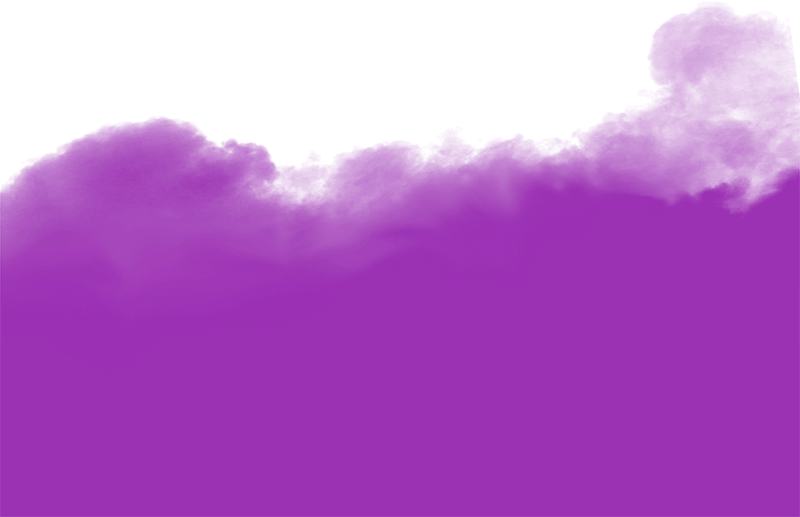

_____________________________________________________2010-2011____________________________________

<!DOCTYPE html>
<html data-version="klecko-" data-root="" lang="en" class="no-js" >
<head id="suppress_all_ads">
    <meta charset="utf-8">
    <meta http-equiv="x-ua-compatible" content="ie=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=2.0" />

    <title>Rate Limited Request (429 error) | Sports-Reference.com</title>

    <link rel="canonical" href="https://www.sports-reference.com/429.html" />

<!-- CSS start -->
 <style>body,html{color:#000;font:14px/1.25 Helvetica Neue,helvetica,arial,sans-serif;margin:0;padding:0}html:not(.backstop){scroll-behavior:smooth}html:not(.backstop) div,html:not(.backstop) span{scroll-snap-margin:2.5em 0 0 0;scroll-margin:2.5em 0 0 0}body{-webkit-text-size-adjust:none;-moz-text-size-adjust:none;-ms-text-size-adjust:none;background:#c9cbcd;position:relative;z-index:0}a img{border:0}li,ol,ul{list-style-type:no
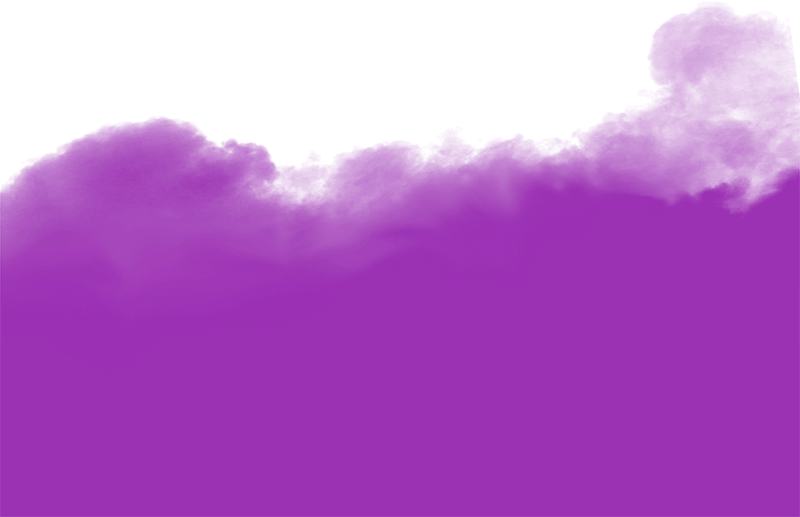

_____________________________________________________2009-2010____________________________________

<!DOCTYPE html>
<html data-version="klecko-" data-root="" lang="en" class="no-js" >
<head id="suppress_all_ads">
    <meta charset="utf-8">
    <meta http-equiv="x-ua-compatible" content="ie=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=2.0" />

    <title>Rate Limited Request (429 error) | Sports-Reference.com</title>

    <link rel="canonical" href="https://www.sports-reference.com/429.html" />

<!-- CSS start -->
 <style>body,html{color:#000;font:14px/1.25 Helvetica Neue,helvetica,arial,sans-serif;margin:0;padding:0}html:not(.backstop){scroll-behavior:smooth}html:not(.backstop) div,html:not(.backstop) span{scroll-snap-margin:2.5em 0 0 0;scroll-margin:2.5em 0 0 0}body{-webkit-text-size-adjust:none;-moz-text-size-adjust:none;-ms-text-size-adjust:none;background:#c9cbcd;position:relative;z-index:0}a img{border:0}li,ol,ul{list-style-type:no
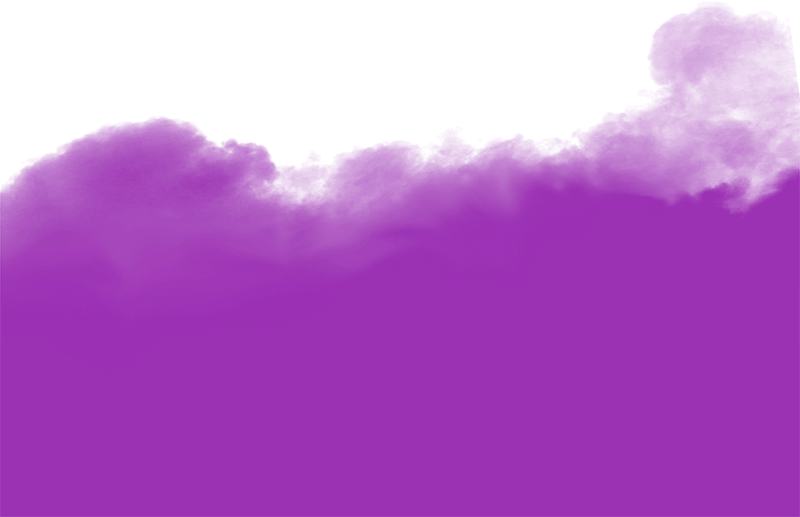

_____________________________________________________2008-2009____________________________________

<!DOCTYPE html>
<html data-version="klecko-" data-root="" lang="en" class="no-js" >
<head id="suppress_all_ads">
    <meta charset="utf-8">
    <meta http-equiv="x-ua-compatible" content="ie=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=2.0" />

    <title>Rate Limited Request (429 error) | Sports-Reference.com</title>

    <link rel="canonical" href="https://www.sports-reference.com/429.html" />

<!-- CSS start -->
 <style>body,html{color:#000;font:14px/1.25 Helvetica Neue,helvetica,arial,sans-serif;margin:0;padding:0}html:not(.backstop){scroll-behavior:smooth}html:not(.backstop) div,html:not(.backstop) span{scroll-snap-margin:2.5em 0 0 0;scroll-margin:2.5em 0 0 0}body{-webkit-text-size-adjust:none;-moz-text-size-adjust:none;-ms-text-size-adjust:none;background:#c9cbcd;position:relative;z-index:0}a img{border:0}li,ol,ul{list-style-type:no
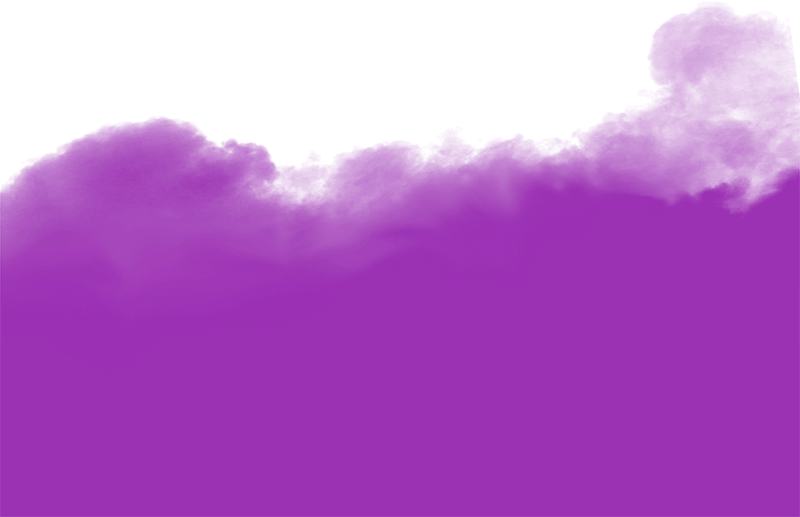

_____________________________________________________2007-2008____________________________________

<!DOCTYPE html>
<html data-version="klecko-" data-root="" lang="en" class="no-js" >
<head id="suppress_all_ads">
    <meta charset="utf-8">
    <meta http-equiv="x-ua-compatible" content="ie=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=2.0" />

    <title>Rate Limited Request (429 error) | Sports-Reference.com</title>

    <link rel="canonical" href="https://www.sports-reference.com/429.html" />

<!-- CSS start -->
 <style>body,html{color:#000;font:14px/1.25 Helvetica Neue,helvetica,arial,sans-serif;margin:0;padding:0}html:not(.backstop){scroll-behavior:smooth}html:not(.backstop) div,html:not(.backstop) span{scroll-snap-margin:2.5em 0 0 0;scroll-margin:2.5em 0 0 0}body{-webkit-text-size-adjust:none;-moz-text-size-adjust:none;-ms-text-size-adjust:none;background:#c9cbcd;position:relative;z-index:0}a img{border:0}li,ol,ul{list-style-type:no
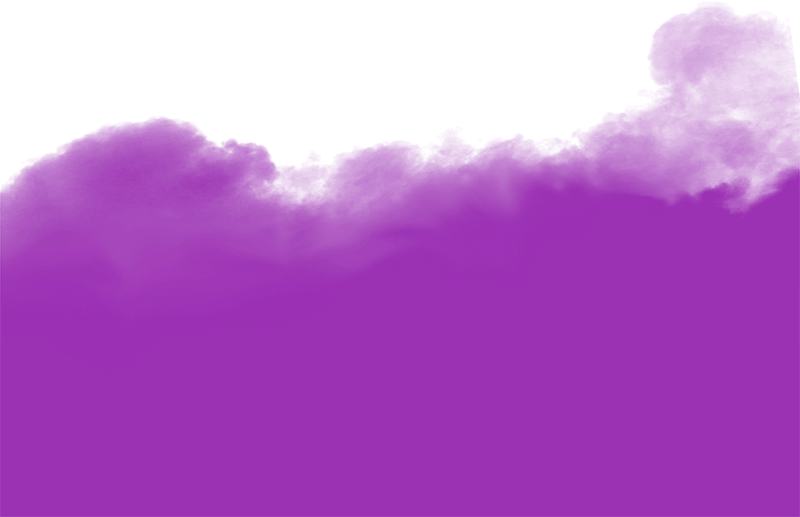

_____________________________________________________2006-2007____________________________________

<!DOCTYPE html>
<html data-version="klecko-" data-root="" lang="en" class="no-js" >
<head id="suppress_all_ads">
    <meta charset="utf-8">
    <meta http-equiv="x-ua-compatible" content="ie=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=2.0" />

    <title>Rate Limited Request (429 error) | Sports-Reference.com</title>

    <link rel="canonical" href="https://www.sports-reference.com/429.html" />

<!-- CSS start -->
 <style>body,html{color:#000;font:14px/1.25 Helvetica Neue,helvetica,arial,sans-serif;margin:0;padding:0}html:not(.backstop){scroll-behavior:smooth}html:not(.backstop) div,html:not(.backstop) span{scroll-snap-margin:2.5em 0 0 0;scroll-margin:2.5em 0 0 0}body{-webkit-text-size-adjust:none;-moz-text-size-adjust:none;-ms-text-size-adjust:none;background:#c9cbcd;position:relative;z-index:0}a img{border:0}li,ol,ul{list-style-type:no
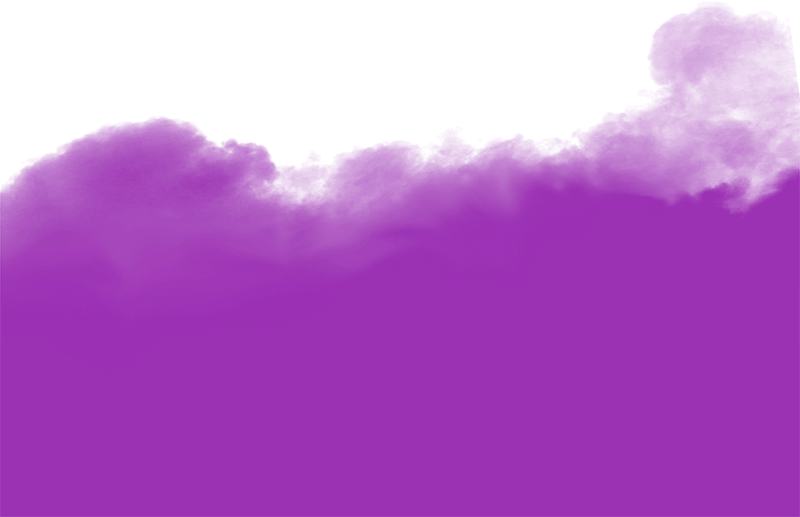

_____________________________________________________2005-2006____________________________________

<!DOCTYPE html>
<html data-version="klecko-" data-root="" lang="en" class="no-js" >
<head id="suppress_all_ads">
    <meta charset="utf-8">
    <meta http-equiv="x-ua-compatible" content="ie=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=2.0" />

    <title>Rate Limited Request (429 error) | Sports-Reference.com</title>

    <link rel="canonical" href="https://www.sports-reference.com/429.html" />

<!-- CSS start -->
 <style>body,html{color:#000;font:14px/1.25 Helvetica Neue,helvetica,arial,sans-serif;margin:0;padding:0}html:not(.backstop){scroll-behavior:smooth}html:not(.backstop) div,html:not(.backstop) span{scroll-snap-margin:2.5em 0 0 0;scroll-margin:2.5em 0 0 0}body{-webkit-text-size-adjust:none;-moz-text-size-adjust:none;-ms-text-size-adjust:none;background:#c9cbcd;position:relative;z-index:0}a img{border:0}li,ol,ul{list-style-type:no
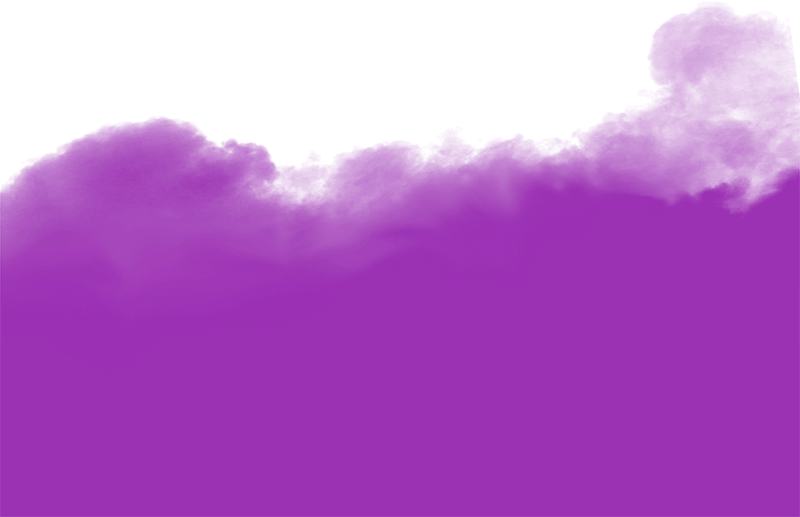

_____________________________________________________2004-2005____________________________________

<!DOCTYPE html>
<html data-version="klecko-" data-root="" lang="en" class="no-js" >
<head id="suppress_all_ads">
    <meta charset="utf-8">
    <meta http-equiv="x-ua-compatible" content="ie=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=2.0" />

    <title>Rate Limited Request (429 error) | Sports-Reference.com</title>

    <link rel="canonical" href="https://www.sports-reference.com/429.html" />

<!-- CSS start -->
 <style>body,html{color:#000;font:14px/1.25 Helvetica Neue,helvetica,arial,sans-serif;margin:0;padding:0}html:not(.backstop){scroll-behavior:smooth}html:not(.backstop) div,html:not(.backstop) span{scroll-snap-margin:2.5em 0 0 0;scroll-margin:2.5em 0 0 0}body{-webkit-text-size-adjust:none;-moz-text-size-adjust:none;-ms-text-size-adjust:none;background:#c9cbcd;position:relative;z-index:0}a img{border:0}li,ol,ul{list-style-type:no
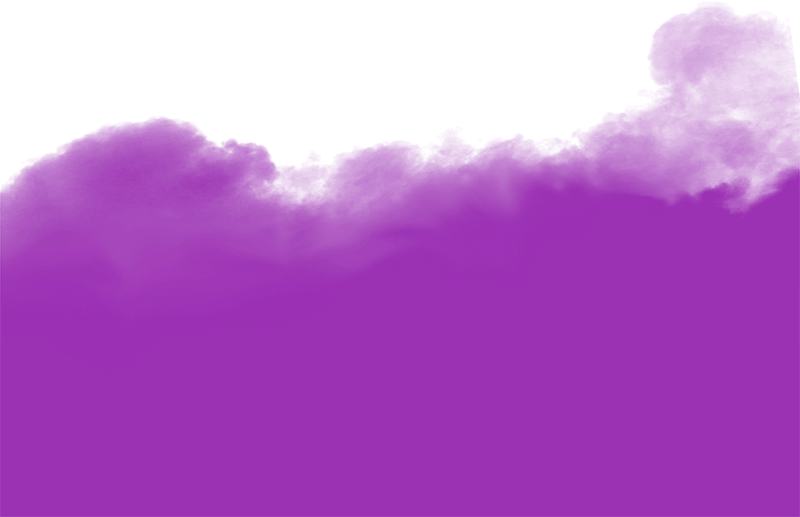

_____________________________________________________2003-2004____________________________________

<!DOCTYPE html>
<html data-version="klecko-" data-root="" lang="en" class="no-js" >
<head id="suppress_all_ads">
    <meta charset="utf-8">
    <meta http-equiv="x-ua-compatible" content="ie=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=2.0" />

    <title>Rate Limited Request (429 error) | Sports-Reference.com</title>

    <link rel="canonical" href="https://www.sports-reference.com/429.html" />

<!-- CSS start -->
 <style>body,html{color:#000;font:14px/1.25 Helvetica Neue,helvetica,arial,sans-serif;margin:0;padding:0}html:not(.backstop){scroll-behavior:smooth}html:not(.backstop) div,html:not(.backstop) span{scroll-snap-margin:2.5em 0 0 0;scroll-margin:2.5em 0 0 0}body{-webkit-text-size-adjust:none;-moz-text-size-adjust:none;-ms-text-size-adjust:none;background:#c9cbcd;position:relative;z-index:0}a img{border:0}li,ol,ul{list-style-type:no
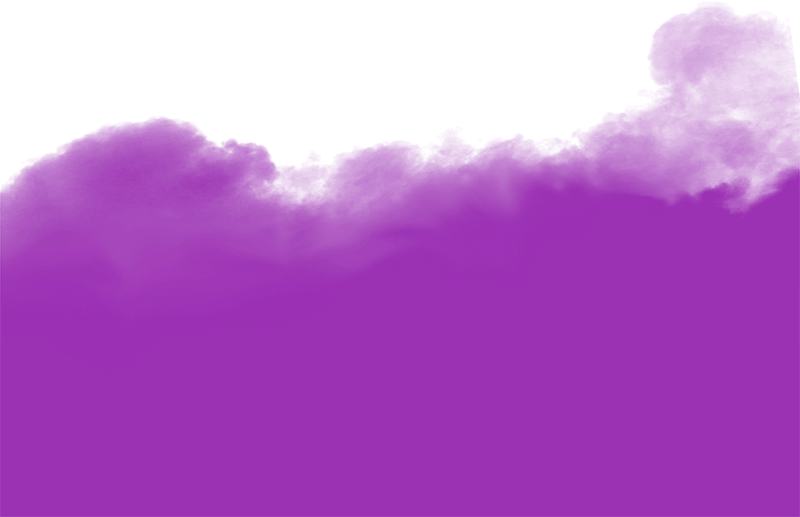

_____________________________________________________2002-2003____________________________________

<!DOCTYPE html>
<html data-version="klecko-" data-root="" lang="en" class="no-js" >
<head id="suppress_all_ads">
    <meta charset="utf-8">
    <meta http-equiv="x-ua-compatible" content="ie=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=2.0" />

    <title>Rate Limited Request (429 error) | Sports-Reference.com</title>

    <link rel="canonical" href="https://www.sports-reference.com/429.html" />

<!-- CSS start -->
 <style>body,html{color:#000;font:14px/1.25 Helvetica Neue,helvetica,arial,sans-serif;margin:0;padding:0}html:not(.backstop){scroll-behavior:smooth}html:not(.backstop) div,html:not(.backstop) span{scroll-snap-margin:2.5em 0 0 0;scroll-margin:2.5em 0 0 0}body{-webkit-text-size-adjust:none;-moz-text-size-adjust:none;-ms-text-size-adjust:none;background:#c9cbcd;position:relative;z-index:0}a img{border:0}li,ol,ul{list-style-type:no
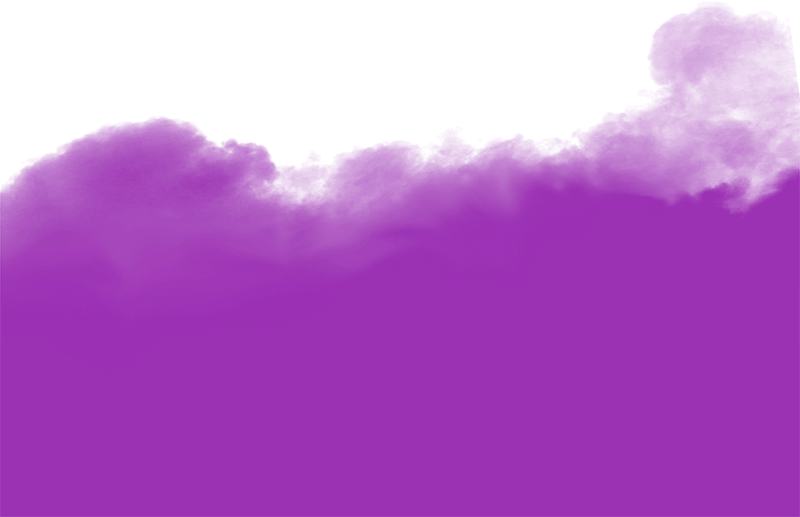

_____________________________________________________2001-2002____________________________________

<!DOCTYPE html>
<html data-version="klecko-" data-root="" lang="en" class="no-js" >
<head id="suppress_all_ads">
    <meta charset="utf-8">
    <meta http-equiv="x-ua-compatible" content="ie=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=2.0" />

    <title>Rate Limited Request (429 error) | Sports-Reference.com</title>

    <link rel="canonical" href="https://www.sports-reference.com/429.html" />

<!-- CSS start -->
 <style>body,html{color:#000;font:14px/1.25 Helvetica Neue,helvetica,arial,sans-serif;margin:0;padding:0}html:not(.backstop){scroll-behavior:smooth}html:not(.backstop) div,html:not(.backstop) span{scroll-snap-margin:2.5em 0 0 0;scroll-margin:2.5em 0 0 0}body{-webkit-text-size-adjust:none;-moz-text-size-adjust:none;-ms-text-size-adjust:none;background:#c9cbcd;position:relative;z-index:0}a img{border:0}li,ol,ul{list-style-type:no
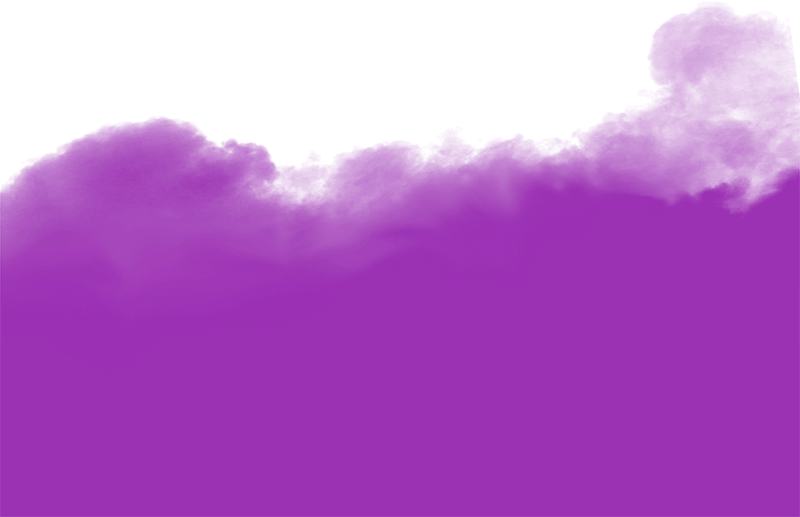

_____________________________________________________2000-2001____________________________________

<!DOCTYPE html>
<html data-version="klecko-" data-root="" lang="en" class="no-js" >
<head id="suppress_all_ads">
    <meta charset="utf-8">
    <meta http-equiv="x-ua-compatible" content="ie=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=2.0" />

    <title>Rate Limited Request (429 error) | Sports-Reference.com</title>

    <link rel="canonical" href="https://www.sports-reference.com/429.html" />

<!-- CSS start -->
 <style>body,html{color:#000;font:14px/1.25 Helvetica Neue,helvetica,arial,sans-serif;margin:0;padding:0}html:not(.backstop){scroll-behavior:smooth}html:not(.backstop) div,html:not(.backstop) span{scroll-snap-margin:2.5em 0 0 0;scroll-margin:2.5em 0 0 0}body{-webkit-text-size-adjust:none;-moz-text-size-adjust:none;-ms-text-size-adjust:none;background:#c9cbcd;position:relative;z-index:0}a img{border:0}li,ol,ul{list-style-type:no
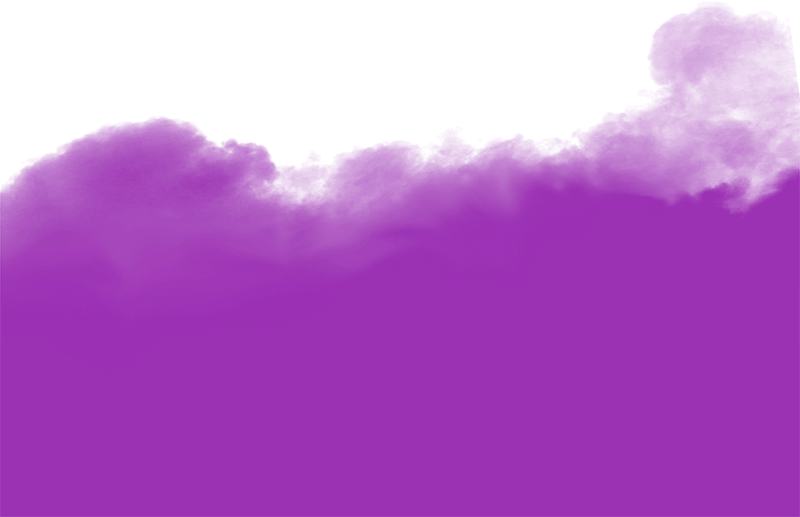

In [60]:
for year in years:
    HTML_markup = (requests.get(f"https://fbref.com/en/squads/361ca564/{year}/Tottenham-Hotspur-Stats")).text
    #print(f"_____________________________________________________{year}____________________________________")
    #print(HTML_markup)